[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PTB-MR/mrpro/blob/main/examples/notebooks/t1_mapping_with_grad_acq.ipynb) [![Download notebook](https://img.shields.io/badge/Download-notebook-blue?logo=jupyter)](path:t1_mapping_with_grad_acq.ipynb)

In [1]:
import importlib

if not importlib.util.find_spec('mrpro'):
    %pip install mrpro[notebook]

# $T_1$ mapping from a continuous Golden radial acquisition

In [2]:
# Imports
import shutil
import tempfile
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import zenodo_get
from mpl_toolkits.axes_grid1 import make_axes_locatable  # type: ignore [import-untyped]
from mrpro.algorithms.optimizers import adam
from mrpro.algorithms.reconstruction import DirectReconstruction
from mrpro.data import KData
from mrpro.data.traj_calculators import KTrajectoryIsmrmrd
from mrpro.operators import ConstraintsOp, MagnitudeOp
from mrpro.operators.functionals import MSE
from mrpro.operators.models import TransientSteadyStateWithPreparation
from mrpro.utils import split_idx

### Overview
In this acquisition, a single inversion pulse is played out, followed by a continuous data acquisition with a
a constant flip angle $\alpha$. Data acquisition is carried out with a 2D Golden angle radial trajectory. The acquired
data can be divided into different dynamic time frames, each corresponding to a different inversion time. A signal
model can then be fitted to this data to obtain a $T_1$ map.

More information can be found in:
Kerkering KM, Schulz-Menger J, Schaeffter T, Kolbitsch C (2023). Motion-corrected model-based reconstruction for 2D
myocardial $T_1$ mapping. *Magnetic Resonance in Medicine*, 90(3):1086-1100, [10.1002/mrm.29699](https://doi.org/10.1002/mrm.29699)

The number of time frames and hence the number of radial lines per time frame, can in principle be chosen arbitrarily.
However, a tradeoff between image quality (more radial lines per dynamic) and
temporal resolution to accurately capture the signal behavior (fewer radial lines) needs to be found.

During data acquisition, the magnetization $M_z(t)$ can be described by the signal model:

$$
  M_z(t) = M_0^* + (M_0^{init} - M_0^*)e^{(-t / T_1^*)} \quad (1)
$$

where the effective longitudinal relaxation time is given by:

$$
  T_1^* = \frac{1}{\frac{1}{T_1} - \frac{1}{T_R} \ln(\cos(\alpha))}
$$

and the steady-state magnetization is

$$
  M_0^* = M_0 \frac{T_1^*}{T_1} .
$$

The initial magnetization $M_0^{init}$ after an inversion pulse is $-M_0$. Nevertheless, commonly after an inversion
pulse, a strong spoiler gradient is played out to remove any residual transversal magnetization due to
imperfections of the inversion pulse. During the spoiler gradient, the magnetization recovers with $T_1$. Commonly,
the duration of this spoiler gradient $\Delta t$ is between 10 to 20 ms. This leads to the initial magnetization

$$
 M_0^{init} = M_0(1 - 2e^{(-\Delta t / T_1)}) .
$$

In this example, we are going to:
- Reconstruct a single high quality image using all acquired radial lines.
- Split the data into multiple dynamics and reconstruct these dynamic images
- Define a signal model and a loss function to obtain the $T_1$ maps

In [3]:
# Download raw data in ISMRMRD format from zenodo into a temporary directory
data_folder = Path(tempfile.mkdtemp())
dataset = '13207352'
zenodo_get.zenodo_get([dataset, '-r', 5, '-o', data_folder])  # r: retries

Title: 2D Dynamic Golden radial MR raw data
Keywords: MR raw data; T1 mapping; Golden radial
Publication date: 2024-08-03
DOI: 10.5281/zenodo.13207352
Total size: 4.7 MB

Link: https://zenodo.org/records/13207352/files/2D_GRad_map_t1.h5   size: 4.7 MB



Checksum is correct. (6235051bba0d04fe8df8fb6199da44d0)
All files have been downloaded.


## Reconstruct average image
Reconstruct one image as the average over all radial lines

In [4]:
# Read raw data and trajectory
kdata = KData.from_file(data_folder / '2D_GRad_map_t1.h5', KTrajectoryIsmrmrd())

# Perform the reconstruction
reconstruction = DirectReconstruction(kdata)
img_average = reconstruction(kdata)

Text(0.5, 1.0, 'Average image')

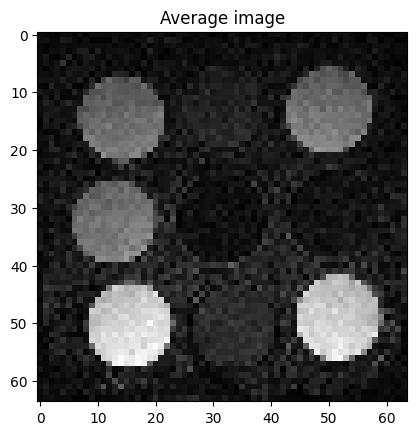

In [5]:
# Visualize average image
plt.figure()
plt.imshow(img_average.rss()[0, 0, :, :], cmap='gray')
plt.title('Average image')

## Split the data into dynamics and reconstruct dynamic images
We split the k-space data into different dynamics with 30 radial lines, each and no data overlap between the different
dynamics. Then we again perform a simple direct reconstruction, where we use the same coil sensitivity map (which we
estimated above) for each dynamic.

In [6]:
idx_dynamic = split_idx(torch.argsort(kdata.header.acq_info.acquisition_time_stamp[0, 0, :, 0]), 30, 0)
kdata_dynamic = kdata.split_k1_into_other(idx_dynamic, other_label='repetition')

In [7]:
# Perform the reconstruction
# Here we use the same coil sensitivity map for all dynamics
reconstruction_dynamic = DirectReconstruction(kdata_dynamic, csm=reconstruction.csm)
img_dynamic = reconstruction_dynamic(kdata_dynamic)
# Get absolute value of complex image and normalize the images
img_rss_dynamic = img_dynamic.rss()
img_rss_dynamic /= img_rss_dynamic.max()

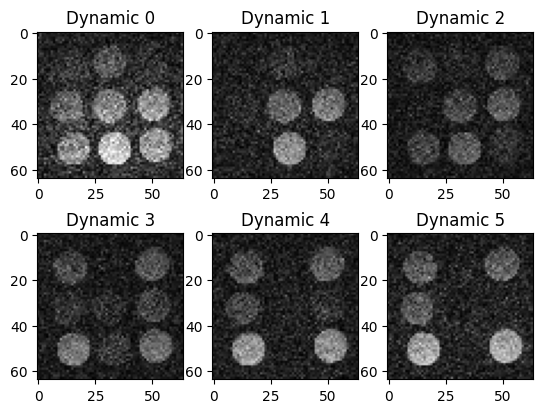

In [8]:
# Visualize the first six dynamic images
fig, ax = plt.subplots(2, 3, squeeze=False)
for idx, cax in enumerate(ax.flatten()):
    cax.imshow(img_rss_dynamic[idx, 0, :, :], cmap='gray', vmin=0, vmax=0.8)
    cax.set_title(f'Dynamic {idx}')

## Estimate $T_1$ map

### Signal model
We use a three parameter signal model $q(M_0, T_1, \alpha)$.

As known input, the model needs information about the time $t$ (`sampling_time`) in Eq. (1) since the inversion pulse.
This can be calculated from the `acquisition_time_stamp`. If we average the `acquisition_time_stamp`-values for each
dynamic image and subtract the first `acquisition_time_stamp`, we get the mean time since the inversion pulse for each
dynamic. Note: The time taken by the spoiler gradient is taken into consideration in the
`TransientSteadyStateWithPreparation`-model and does not have to be added here. Another important thing to note is
that the `acquisition_time_stamp` is not given in time units but in vendor-specific time stamp units. For the Siemens
data used here, one time stamp corresponds to 2.5 ms.

In [9]:
sampling_time = torch.mean(kdata_dynamic.header.acq_info.acquisition_time_stamp[:, 0, :, 0].to(torch.float32), dim=-1)
# Subtract time stamp of first radial line
sampling_time -= kdata_dynamic.header.acq_info.acquisition_time_stamp[0, 0, 0, 0]
# Convert to seconds
sampling_time *= 2.5 / 1000

We also need the repetition time between two RF-pulses. There is a parameter `tr` in the header, but this describes
the time "between the beginning of a pulse sequence and the beginning of the succeeding (essentially identical) pulse
sequence" (see [DICOM Standard Browser](https://dicom.innolitics.com/ciods/mr-image/mr-image/00180080)). We have one
inversion pulse at the beginning, which is never repeated and hence `tr` is the duration of the entire scan.
Therefore, we have to use the parameter `echo_spacing`, which describes the time between two gradient echoes.

In [10]:
if kdata_dynamic.header.echo_spacing is None:
    raise ValueError('Echo spacing needs to be defined.')
else:
    repetition_time = kdata_dynamic.header.echo_spacing[0]

Finally, we have to specify the duration of the spoiler gradient. Unfortunately, we cannot get this information from
the acquired data, but we have to know the value and set it by hand to 20 ms. Now we can define the signal model.

In [11]:
model_op = TransientSteadyStateWithPreparation(
    sampling_time, repetition_time, m0_scaling_preparation=-1, delay_after_preparation=0.02
)

The reconstructed image data is complex-valued. We could fit a complex $M_0$ to the data, but in this case it is more
robust to fit $|q(M_0, T_1, \alpha)|$ to the magnitude of the image data. We therefore combine our model with a
`MagnitudeOp`.

In [12]:
magnitude_model_op = MagnitudeOp() @ model_op

### Constraints
$T_1$ and $\alpha$ need to be positive. Based on the knowledge of the phantom, we can constrain $T_1$ between 50 ms
and 3 s. Further, we can constrain $\alpha$. Although the effective flip angle can vary, it can only vary by a
certain percentage relative to the nominal flip angle. Here, we chose a maximum deviation from the nominal flip angle
of 50%.

In [13]:
if kdata_dynamic.header.fa is None:
    raise ValueError('Nominal flip angle needs to be defined.')
else:
    nominal_flip_angle = float(kdata_dynamic.header.fa[0])

constraints_op = ConstraintsOp(bounds=((None, None), (0.05, 3.0), (nominal_flip_angle * 0.5, nominal_flip_angle * 1.5)))

### Loss function
As a loss function for the optimizer, we calculate the mean squared error between the image data $x$ and our signal
model $q$.

In [14]:
mse_loss = MSE(img_rss_dynamic)

Now we can simply combine the loss function, the signal model and the constraints to solve

$$
 \min_{M_0, T_1, \alpha} || |q(M_0, T_1, \alpha)| - x||_2^2
$$

In [15]:
functional = mse_loss @ magnitude_model_op @ constraints_op

### Carry out fit

In [16]:
# The shortest echo time is a good approximation for the equilibrium magnetization
m0_start = img_rss_dynamic[0, ...]
# 1 s a good starting value for T1
t1_start = torch.ones(m0_start.shape, dtype=torch.float32)
# and the nominal flip angle a good starting value for the actual flip angle
flip_angle_start = torch.ones(m0_start.shape, dtype=torch.float32) * kdata_dynamic.header.fa

In [17]:
# Hyperparameters for optimizer
max_iter = 500
lr = 1e-2

# Run optimization
params_result = adam(functional, [m0_start, t1_start, flip_angle_start], max_iter=max_iter, lr=lr)
params_result = constraints_op(*params_result)
m0, t1, flip_angle = (p.detach() for p in params_result)

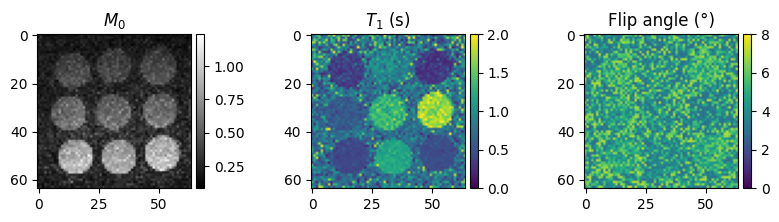

In [18]:
# Visualize parametric maps
fig, axes = plt.subplots(1, 3, figsize=(10, 2), squeeze=False)
colorbar_ax = [make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05) for ax in axes[0, :]]
im = axes[0, 0].imshow(m0[0, ...].abs(), cmap='gray')
axes[0, 0].set_title('$M_0$')
fig.colorbar(im, cax=colorbar_ax[0])
im = axes[0, 1].imshow(t1[0, ...], vmin=0, vmax=2)
axes[0, 1].set_title('$T_1$ (s)')
fig.colorbar(im, cax=colorbar_ax[1])
im = axes[0, 2].imshow(flip_angle[0, ...] / torch.pi * 180, vmin=0, vmax=8)
axes[0, 2].set_title('Flip angle (°)')
fig.colorbar(im, cax=colorbar_ax[2])

### Next steps
The quality of the final $T_1$ maps depends on the quality of the individual dynamic images. Using more advanced image
reconstruction methods, we can improve the image quality and hence the quality of the maps.

Try to exchange `DirectReconstruction` above with `IterativeSENSEReconstruction` and compare the quality of the
$T_1$ maps for different number of iterations (`n_iterations`).

In [19]:
# Clean-up by removing temporary directory
shutil.rmtree(data_folder)